# Going Deeper 02
## 프로젝트: CutMix, Mixup Augmentation 성능 비교

### 프로젝트 구성
1. Augmentation 적용 (1) 데이터 불러오기
2. Augmentation 적용 (2) Augmentation 적용하기
3. 모델 만들기
4. 모델 훈련하기
5. 훈련 과정 시각화하기
6. Augmentation에 의한 모델 성능 비교

### 프로젝트 목표
1. CutMix와 MixUp 기법을 ResNet50 분류기에 적용
    - CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법 찾기
    - Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상
3. 여러가지 Augmentation 기법을 적용한 결과 비교 분석
    - 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화 및 분석

# 1.  데이터 불러오기

In [89]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# 필요한 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('슝💨')

슝💨


In [90]:
# GPU 환경 확인하기
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Datat Info
- 사용할 데이터는 [stanford_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs)입니다.
- Stanford Dogs 데이터 세트에는 전 세계의 120개 품종의 개 이미지가 포함되어 있습니다. 이 데이터 세트는 세분화된 이미지 분류 작업을 위해 ImageNet의 이미지와 주석을 사용하여 구축되었습니다. 
- 총 image 개수 : 20,580
- train: 12,000 / test: 8,580

In [91]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

print('슝💨')

슝💨


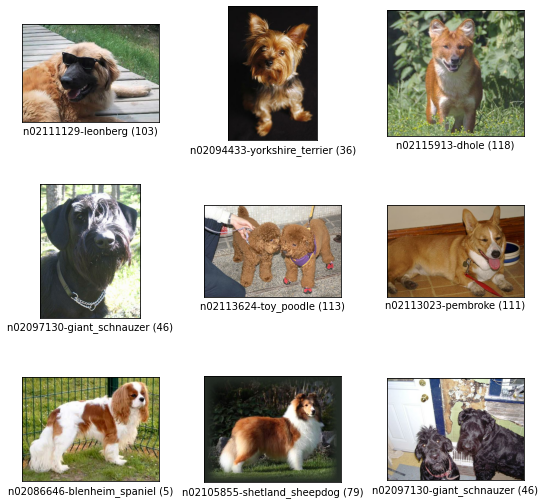

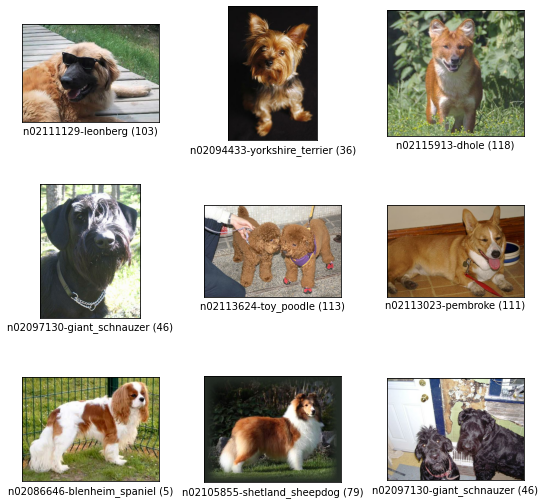

In [92]:
# 다운로드한 데이터 확인
tfds.show_examples(ds_train, ds_info)

# 2. Augmentation 적용하기

In [93]:
# 기본 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224]) # (224, 224) 사이즈로 resize
    return tf.cast(image, tf.float32) / 255., label # 0~1 사이의 float32 Normalize

print('슝💨')

슝💨


위의 normalize_and_resize_img 함수는 train, test 용으로 사용될 모든 이미지에 적용됨

In [94]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('슝💨')

슝💨


random augmentation 중 random_flip_left_right(), random_brightness() 활용. 이미지 분류 문제에서는 좌우 대칭이 문제가 생기지 않고, 상하 대칭은 테스트 데이터셋의 이미지 특성상 위아래가 뒤집힌 사진이 없으므로 도움이 되지 않을 것이라 적용하지 않음. brightness를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 함.

#### random augmentation 함수
- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

In [95]:
# dataset을 가공하는 메인 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
    normalize_and_resize_img,
    num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
        augment,
        num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝💨')

슝💨


원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수를 apply_normalize_on_dataset() 정의

- 일반적인 데이터 전처리 과정
- normalize, resize, augmentation, shuffle 적용
- 주의점: shuffle, augmentation은 test dataset에 적용하면 안 됨

여러 결과를 조합하기 위한 ensemble 방법 중 하나로 테스트 데이터셋에 augmentation을 적용하는 test-time augmentation 방법이 있음

- 참고 [TTA(test time augmentation) with 케라스](https://hwiyong.tistory.com/215)

## (1) Augmentation 기법: Cutmix Augmentation

### CutMix augmentation
- 관련 논문: [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)
- 관련 자료: [CutMix and MixUp on GPU/TPU](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)

**CutMix**는 이름 그대로 이미지 데이터를 자르고 섞는 기법입니다. 아래 사진을 참고해보도록 하겠습니다.

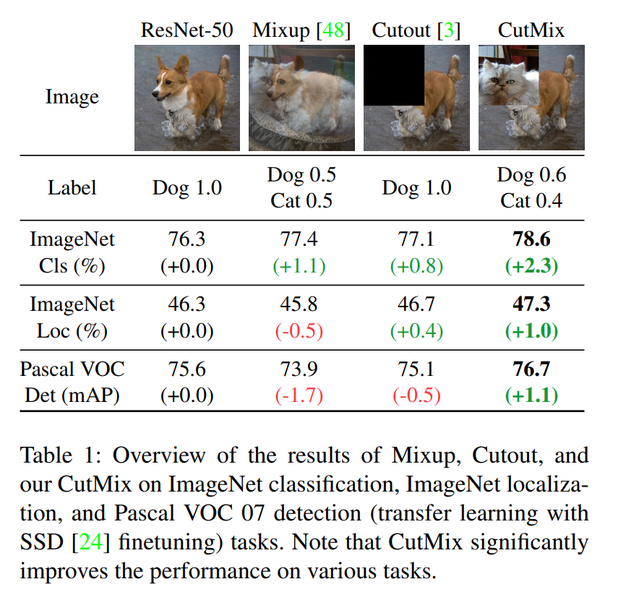

**Mixup**은 특정 비율로 픽셀별 값을 섞는 방식, **Cutout**은 이미지를 자르는 방식입니다. **CutMix**는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다.

### 1) 이미지 섞기

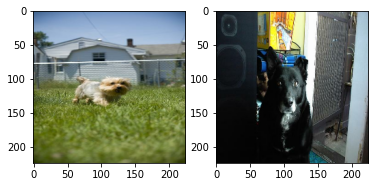

In [121]:
# 데이테섯에서 이미지 2개 가져오기
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

두 개의 이미지를 얻었습니다.

이 중 첫 번째 이미지 a를 바탕 이미지로 하고, 삽입할 이미지를 b로 둔다면, a에 삽입될 영역의 바운딩 박스의 위치를 구하는 함수를 구현해 보겠습니다.

이미지 a, b 모두 (224,224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo에서는 width, heiht가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있습니다.

때문에 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해봅니다.

In [122]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x: ', x_min, x_max)
print('y: ', y_min, y_max)

x:  tf.Tensor(38, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y:  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(135, shape=(), dtype=int32)


바탕 이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해봅시다.

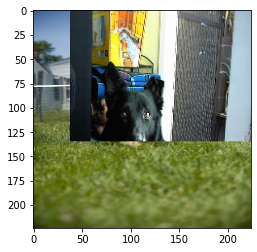

In [123]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2) 라벨 섞기

CutMix에서는 면적에 비례해서 라벨을 섞습니다. 섞인 이미지의 전체 이미지 대비 비율을 계산하여 두 가지 라벨의 비율로 더합니다.

이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 one-hot 인코딩이 아니라 A, B 클래스에 해당하는 인덱스에 각각 비율을 배분하는 방식을 사용합니다.

In [124]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.49956155, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [125]:
# mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('슝💨')

슝💨


## (2) Augmentation 기법: Mixup Augmentation

Mixup은 앞에서 보여드린 CutMix보다 간단하게 이미지와 라벨을 섞어줍니다. 두 개의 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단합니다.

- 관련 논문: [mixup:Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)

두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.

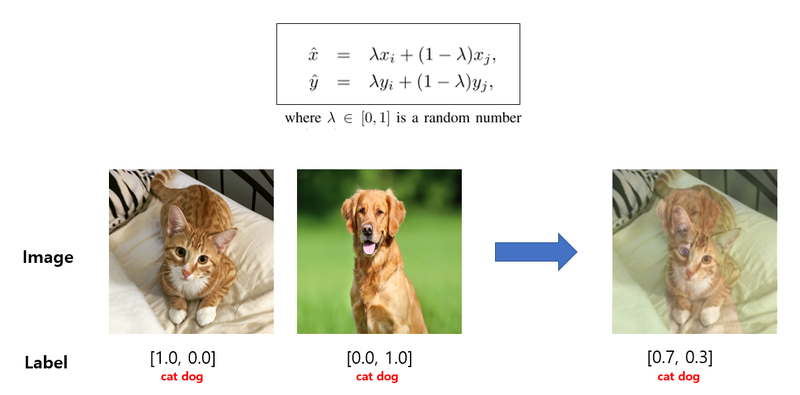

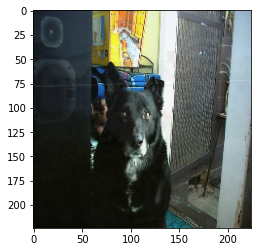

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.09371376 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.90628624 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [127]:
num_classes = ds_info.features['label'].num_classes

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 mixup_2_images 함수를 구현했습니다. 이 함수를 활용하여 배치 단위의 mixup() 함수를 구현해봅시다.

In [128]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('슝💨')

슝💨


In [129]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [130]:
# CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset() 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝💨')

슝💨


bathc() 뒤에 CutMix가 오도록 만들어야 함. CutMix는 배치 안에 있는 이미지들끼리만 섞어서 미리 배치 단위로 데이터셋을 정렬한 후에 CutMix가 적용되어야 함

In [134]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('슝💨')

슝💨


tensorflow dataset에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록하고, 하나는 True로 주어서 augmentation이 적용되도록 합니다.

이제 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행합니다.

# 3. 모델 만들기

In [138]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('슝💨')

슝💨


In [139]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('슝💨')

슝💨


In [140]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('슝💨')

슝💨


In [143]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('슝💨')

슝💨


# 4. 모델 훈련하기

In [148]:
# Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해야 합니다.

sparse_categorical_crossentropy()를 사용하지 못하는 이유는 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 **label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환**되었기 때문입니다.

In [149]:
history_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 368s 455ms/step - loss: 3.1634 - accuracy: 0.2758 - val_loss: 3.3872 - val_accuracy: 0.2079
Epoch 2/20
750/750 [==============================] - 343s 458ms/step - loss: 0.9312 - accuracy: 0.7431 - val_loss: 1.0304 - val_accuracy: 0.6981
Epoch 3/20
750/750 [==============================] - 343s 457ms/step - loss: 0.3379 - accuracy: 0.9171 - val_loss: 0.9380 - val_accuracy: 0.7227
Epoch 4/20
750/750 [==============================] - 343s 457ms/step - loss: 0.0998 - accuracy: 0.9869 - val_loss: 0.9016 - val_accuracy: 0.7374
Epoch 5/20
750/750 [==============================] - 343s 457ms/step - loss: 0.0312 - accuracy: 0.9993 - val_loss: 0.8985 - val_accuracy: 0.7430
Epoch 6/20
750/750 [==============================] - 343s 458ms/step - loss: 0.0178 - accuracy: 0.9997 - val_loss: 0.9298 - val_accuracy: 0.7408
Epoch 7/20
750/750 [==============================] - 344s 459ms/step - loss: 0.0135 - accuracy: 0.9995 - val_loss: 0.9150 -

In [150]:
history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 350s 459ms/step - loss: 3.2137 - accuracy: 0.2730 - val_loss: 3.4531 - val_accuracy: 0.1978
Epoch 2/20
750/750 [==============================] - 343s 458ms/step - loss: 1.0925 - accuracy: 0.6853 - val_loss: 1.2031 - val_accuracy: 0.6540
Epoch 3/20
750/750 [==============================] - 343s 457ms/step - loss: 0.6464 - accuracy: 0.8147 - val_loss: 1.0834 - val_accuracy: 0.6840
Epoch 4/20
750/750 [==============================] - 343s 457ms/step - loss: 0.3455 - accuracy: 0.9118 - val_loss: 1.1060 - val_accuracy: 0.6918
Epoch 5/20
750/750 [==============================] - 342s 457ms/step - loss: 0.1769 - accuracy: 0.9637 - val_loss: 1.0221 - val_accuracy: 0.7128
Epoch 6/20
750/750 [==============================] - 342s 456ms/step - loss: 0.0983 - accuracy: 0.9832 - val_loss: 0.9881 - val_accuracy: 0.7295
Epoch 7/20
750/750 [==============================] - 343s 457ms/step - loss: 0.0588 - accuracy: 0.9921 - val_loss: 0.9707 -

In [151]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 352s 461ms/step - loss: 4.3537 - accuracy: 0.1125 - val_loss: 3.5377 - val_accuracy: 0.1849
Epoch 2/20
750/750 [==============================] - 345s 459ms/step - loss: 3.0456 - accuracy: 0.4036 - val_loss: 1.3669 - val_accuracy: 0.6170
Epoch 3/20
750/750 [==============================] - 344s 459ms/step - loss: 2.7102 - accuracy: 0.5146 - val_loss: 1.2480 - val_accuracy: 0.6502
Epoch 4/20
750/750 [==============================] - 344s 459ms/step - loss: 2.5008 - accuracy: 0.5839 - val_loss: 1.2962 - val_accuracy: 0.6442
Epoch 5/20
750/750 [==============================] - 344s 459ms/step - loss: 2.3410 - accuracy: 0.6322 - val_loss: 1.4053 - val_accuracy: 0.6199
Epoch 6/20
750/750 [==============================] - 344s 459ms/step - loss: 2.2035 - accuracy: 0.6791 - val_loss: 1.2190 - val_accuracy: 0.6677
Epoch 7/20
750/750 [==============================] - 344s 459ms/step - loss: 2.1041 - accuracy: 0.7037 - val_loss: 1.3711 -

In [152]:
history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 348s 456ms/step - loss: 4.2801 - accuracy: 0.1290 - val_loss: 4.2673 - val_accuracy: 0.1168
Epoch 2/20
750/750 [==============================] - 342s 455ms/step - loss: 2.9678 - accuracy: 0.4338 - val_loss: 1.4905 - val_accuracy: 0.5852
Epoch 3/20
750/750 [==============================] - 342s 456ms/step - loss: 2.6483 - accuracy: 0.5613 - val_loss: 1.3501 - val_accuracy: 0.6177
Epoch 4/20
750/750 [==============================] - 342s 456ms/step - loss: 2.3880 - accuracy: 0.6513 - val_loss: 1.2659 - val_accuracy: 0.6493
Epoch 5/20
750/750 [==============================] - 342s 456ms/step - loss: 2.2884 - accuracy: 0.6985 - val_loss: 1.2483 - val_accuracy: 0.6578
Epoch 6/20
750/750 [==============================] - 341s 455ms/step - loss: 2.1765 - accuracy: 0.7398 - val_loss: 1.2414 - val_accuracy: 0.6593
Epoch 7/20
750/750 [==============================] - 342s 456ms/step - loss: 2.0969 - accuracy: 0.7652 - val_loss: 1.3095 -

# 5. 훈련 과정 시각화하기

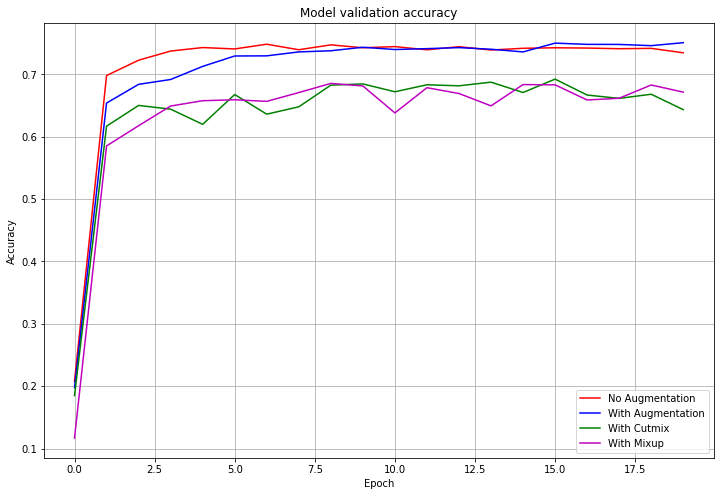

In [153]:
plt.figure(figsize=(12,8))
plt.plot(history_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50 .history['val_accuracy'], 'g')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

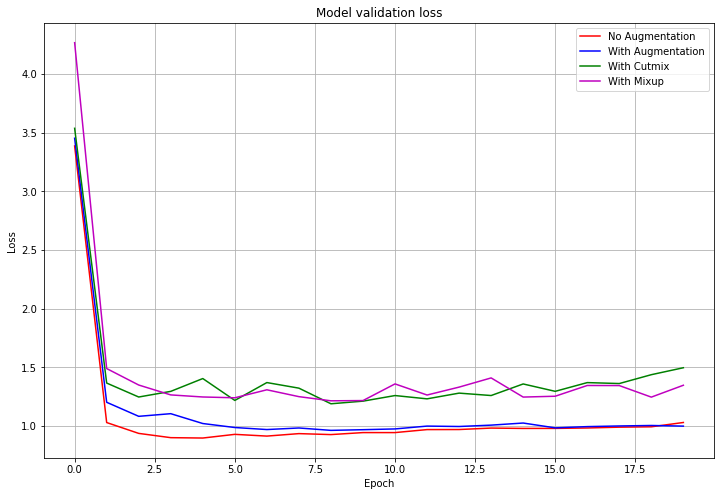

In [154]:
plt.figure(figsize=(12,8))
plt.plot(history_no_aug_resnet50.history['val_loss'], 'r')
plt.plot(history_aug_resnet50.history['val_loss'], 'b')
plt.plot(history_cutmix_resnet50 .history['val_loss'], 'g')
plt.plot(history_mixup_resnet50.history['val_loss'], 'm')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

# 6. Augmentation에 의한 모델 성능 비교

In [156]:
import pandas as pd

accuracy_data = {'No Augmentation': history_no_aug_resnet50.history['val_accuracy'],
                 'With Augmentation': history_aug_resnet50.history['val_accuracy'],
                 'With CutMix': history_cutmix_resnet50 .history['val_accuracy'],
                 'With MixUp': history_mixup_resnet50.history['val_accuracy']   
}

accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df[-5:]

,No Augmentation,With Augmentation,With CutMix,With MixUp
15,0.742654,0.750117,0.692397,0.683186
16,0.742188,0.748134,0.666861,0.658932
17,0.741138,0.748018,0.661497,0.661730
18,0.741721,0.746035,0.668144,0.682952
19,0.734608,0.750816,0.643423,0.671525


In [157]:
accuracy_df.describe()

,No Augmentation,With Augmentation,With CutMix,With MixUp
count,20.000000,20.000000,20.000000,20.000000
mean,0.711964,0.703020,0.638165,0.632906
std,0.119140,0.121595,0.108902,0.123941
min,0.207906,0.197761,0.184935,0.116838
25%,0.738631,0.725309,0.644036,0.649429
50%,0.741430,0.738864,0.667269,0.660506
75%,0.742741,0.744111,0.681932,0.679338
max,0.748368,0.750816,0.692397,0.685518


## 모델 성능 비교

### 1. Augmentation vs No Augmentation
그래프에서 No Augmentation이 가장 빠른 속도로 성능 향상을 보이지만, Augmentation이 결과적으로 더 높은 성능을 보여주었다. 마지막 epoch에서 보여준 accuracy는 No Augmentation이 0.734608  Augmentation이 0.750816로 가장 높은 성능을 보여준다.

### 2. Augmentation vs CutMix vs Mixup
Augmentation, CutMix, Mixup가 각각 적용된 세 가지 Dataset 훈련 결과는 0.750816, 0.643423, 0.671525로 나왔다. 분류 정확도 순서는 Augmentation이 가장 높고, CutMix, Mixup보다 낮은 성능 수치를 보여준다. 그 이유로는 바운딩 해주는 박스를 랜덤으로 설정했기 때문에 모델이 class('dog')를 찾는데 어려움이 있을 것이라 예상함.

또한, Mixup보다 CutMix가 더 좋은 성능 결과를 보여줌. 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 Mixup의 방식이 일정 영역을 잘라서 붙여주는 CutMix의 방법보다 조금 더 안정적이었던 것 같음.

### 3. 결론
데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해보았고, 기본 Augmentation 기법이 가장 좋은 성능 결과를 보여주었음. 

## 프로젝트 정리
1. 이번 프로젝트는 No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 등 총 4가지 경우의 Dataset에 대해 훈련된 ResNet50 분류기의 분류 정확도 성능을 비교해보았습니다.
2. Augmentation 기법이 기본적으로 무엇이 있는지 알 수 있었고, 텐서플로우를 사용한 Image Augmentation를 학습할 수 있었습니다.
3. 최신 Data Augmentation 기법을 구현 및 모델에 적용하여 영향도에 대해 직접 분석할 수 있었습니다.